<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC3_2020_NB_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [0]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-06-15 11:55:05--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat’

ising2_label.dat    100%[===================>]  79.13K   128KB/s    in 0.6s    

2020-06-15 11:55:07 (128 KB/s) - ‘ising2_label.dat’ saved [81025/81025]

--2020-06-15 11:55:10--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M   880KB/s    in 29s     

2020-06-15 11:55:39 (649 KB/s) - ‘ising2_conf.dat’ saved [19060775/19060775]

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [0]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(tf.__version__)

2.2.0


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


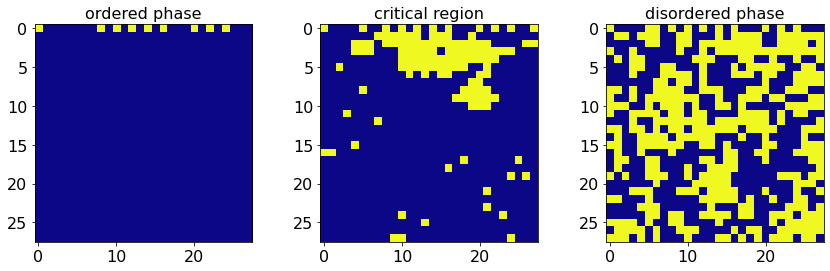

In [0]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [0]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

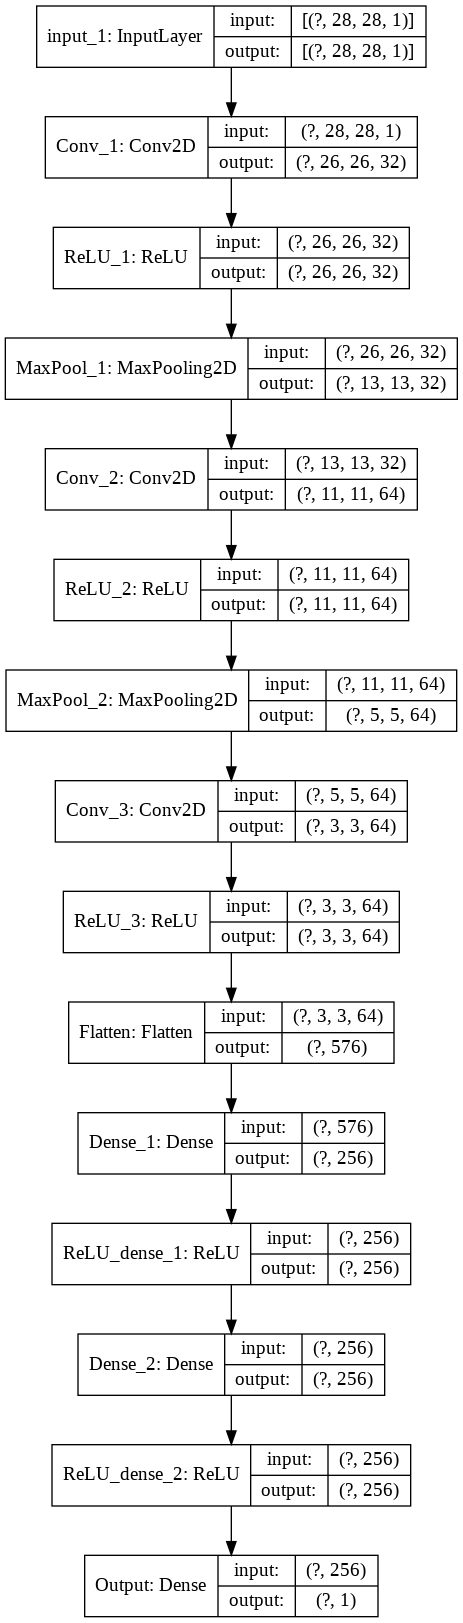

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
#x = data_augmentation(inputs)
x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

#
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
#tf.keras.layers.Conv2D(
#    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
#    dilation_rate=(1, 1), activation=None, use_bias=True,
#    kernel_initializer='glorot_uniform', bias_initializer='zeros',
#    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#    kernel_constraint=None, bias_constraint=None, **kwargs
#)
#tf.keras.layers.ReLU(
#    max_value=None, negative_slope=0, threshold=0, **kwargs
#)
#tf.keras.layers.MaxPool2D(
#    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
#)
# NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
# ridurre la size dell'immagine dopo lapplicazione del filtro

#
# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Layer denso in Keras
#tf.keras.layers.Dense(
#    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
#    **kwargs
#)
x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ model_checkpoint ]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 13ms/step - loss: 0.6767 - mean_absolute_error: 0.5893 - val_loss: 0.2436 - val_mean_absolute_error: 0.4117
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2335 - mean_absolute_error: 0.4099 - val_loss: 0.2127 - val_mean_absolute_error: 0.3889
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2077 - mean_absolute_error: 0.3835 - val_loss: 0.1706 - val_mean_absolute_error: 0.3393
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1623 - mean_absolute_error: 0.3308 - val_loss: 0.1623 - val_mean_absolute_error: 0.3174
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1515 - mean_absolute_error: 0.3170 - val_loss: 0.1413 - val_mean_absolute_error: 0.3037
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1284 - mean_absolute_error: 0.2905 - val_loss: 0.1173 - val_mean_absolute_error: 0.2751
Epoch 7/30
50/50 [=========

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0922 - mean_absolute_error: 0.2309

Test loss (MSE): 0.09222771227359772

Test MAE: 0.23091959953308105


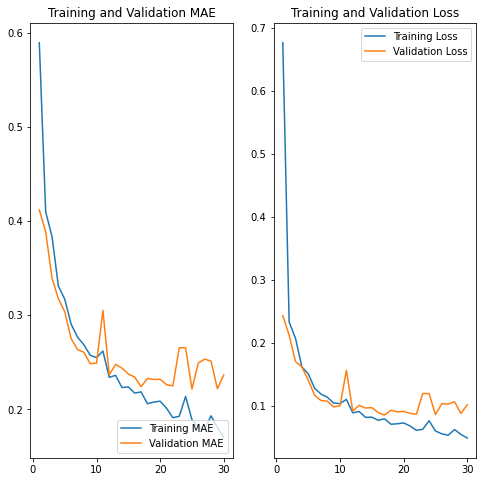

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.709435 VS 0.714393 Diff= -0.004958
Predicted vs True T: 4.213941 VS 4.088540 Diff= 0.125401
Predicted vs True T: 2.813958 VS 3.394810 Diff= -0.580852
Predicted vs True T: 2.520752 VS 2.537430 Diff= -0.016678
Predicted vs True T: 2.085543 VS 2.054070 Diff= 0.031473
Predicted vs True T: 4.699326 VS 4.646900 Diff= 0.052425
Predicted vs True T: 4.689777 VS 4.582670 Diff= 0.107107
Predicted vs True T: 3.522660 VS 3.002150 Diff= 0.520510
Predicted vs True T: 1.364390 VS 1.147520 Diff= 0.216870
Predicted vs True T: 0.709435 VS 1.202230 Diff= -0.492795
Sample MAE:  [0.21490684]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.986


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

**Trovare gi iprparametri ottimali del modello con** *Keras Tuner*

Dato un modello funzionante il passo successivo è quello di ottimizzarne l'archiettura. Questo può essere fatto manualmente (alcuni esempi li abbiamo visti sopra intorducendo il decay del learning rate o introducendo procedure di data_augmentation), oppure in modo sistematico usando tool appositi. Uno di tali tool, semplice e che funziona con keras è appunto [*Keras Tuner*](https://keras-team.github.io/keras-tuner/)


Uso:

1.   si modifica la definizione del modello in modo che acectti un parametro *hp* e in modo tale da modificare gli iperparametri del modello in accordo a diversi metodi di sampling *(hp.Int(), hp.Choice(), ...)*  
2.   si istanzia un oggetto di tipo *tuner* che definisce la strategia di tuning da seguire
3.   si fa partire la ricerca dei parametri e si prina il risultato finale

Esempio pratico:

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

'''def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.ReLU()(x)
  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  return model'''

"def build_model(hp):\n  inputs = keras.Input(shape=(28,28,1))\n  x = keras.layers.Conv2D(\n      filters=hp.Int('filters', min_value=32, max_value=128, step=32),\n      kernel_size=(3,3))(inputs)\n  x = keras.layers.ReLU()(x)\n  x = keras.layers.MaxPool2D((2,2))(x)\n  x = keras.layers.Flatten()(x)\n  x = keras.layers.Dense(\n      units=hp.Int('units', min_value=32, max_value=512, step=32)\n      )(x)\n  x = keras.layers.ReLU()(x)\n  outputs = keras.layers.Dense(1)(x)\n\n  model = keras.Model(inputs=inputs, outputs=outputs)\n  \n  model.compile(\n        optimizer=keras.optimizers.Adam(\n          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),\n        loss='mse',\n        metrics=['mae'])\n  return model"

In [0]:
#pip install -U keras-tuner

In [0]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
'''import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='ottim_dir')'''

"import kerastuner\n \ntuner = kerastuner.tuners.RandomSearch(\n  build_model,\n  objective='val_loss',\n  max_trials=10,\n  executions_per_trial=2,\n  directory='ottim_dir')"

In [0]:
# start optimisation search
#X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

#tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

In [0]:
# Results
#tuner.results_summary()

In [0]:
# Retrieve the best models
'''models = tuner.get_best_models(num_models=2)

test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)'''

"models = tuner.get_best_models(num_models=2)\n\ntest_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)\nprint('\nTest loss (MSE):', test_loss)\nprint('\nTest MAE:', test_mae)"

**Batch Normalization Layers**

Servono a normalizzare gli output del layer precedente in ogni batch: mantengono la media degli output vicina a zero (in ciascun batch) e la deviazione standard vicina a 1. Questo minimizza effetti di diluzione del gradiente e accelera la convergenza (oltre ad avare un effetto di smoothing sulla funzione di loss stimata con il batch di eventi)


In [0]:
#Esempio uso batch normalisation layers
#tf.keras.layers.BatchNormalization(
#    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
#    beta_initializer='zeros', gamma_initializer='ones',
#    moving_mean_initializer='zeros', moving_variance_initializer='ones',
#    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
#    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99,
#    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
#    **kwargs
#)

#  x = keras.layers.Conv2D(32, kernel_size=(3,3))(x)
#  x = keras.layers.BatchNormalization()(x)
#  x = keras.layers.ReLU(x)

#**Svolgimento dei compiti assegnati**

#Compiti:

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

#**Utilizzo della call-back del learning rate con decay**

Testiamo in primo luogo l'utilizzo di una callback che includa un meccanismo di learning-rate decay: impostiamo cioè un learning rate fisso per Adam per le prime 10 epoche del training, mentre per le successive esso diminuisce esponenzialmente con il numero di epoche. Grafichiamo quindi mse e mae dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

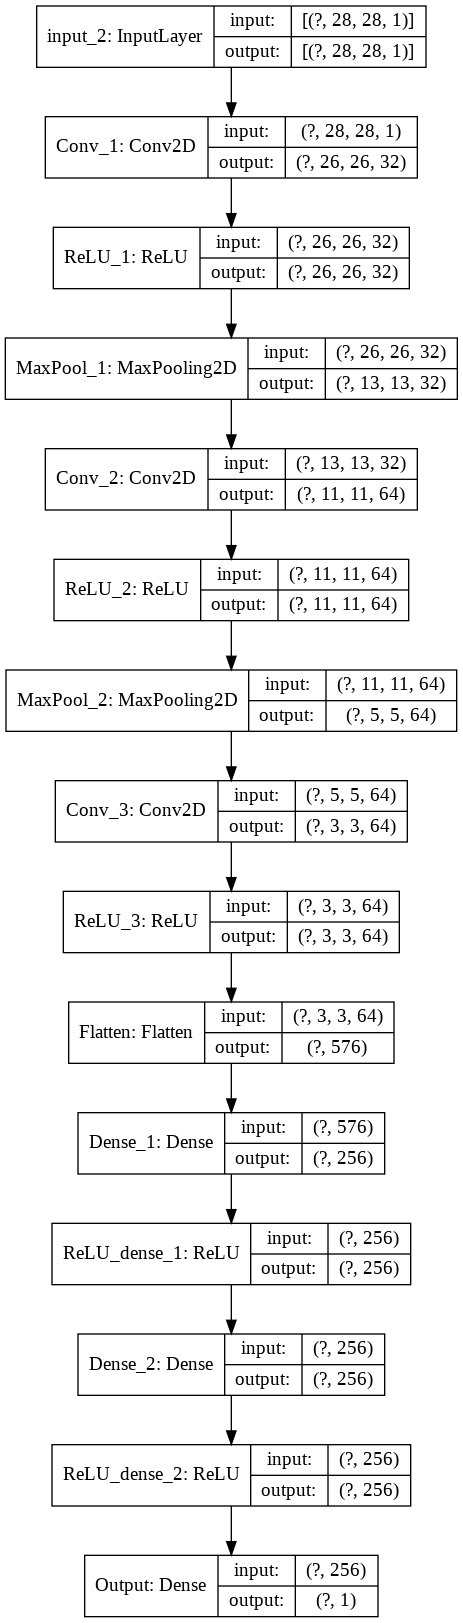

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae

mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [model_checkpoint, lr_scheduler]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.7819 - mean_absolute_error: 0.6209 - val_loss: 0.2436 - val_mean_absolute_error: 0.4206 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2365 - mean_absolute_error: 0.4120 - val_loss: 0.2078 - val_mean_absolute_error: 0.3875 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2050 - mean_absolute_error: 0.3817 - val_loss: 0.1941 - val_mean_absolute_error: 0.3609 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1791 - mean_absolute_error: 0.3512 - val_loss: 0.1560 - val_mean_absolute_error: 0.3261 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1644 - mean_absolute_error: 0.3327 - val_loss: 0.1361 - val_mean_absolute_error: 0.2988 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1400 - mean_absolute_error: 0.3049 - val_loss: 0.14

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0861 - mean_absolute_error: 0.2278

Test loss (MSE): 0.0861075296998024

Test MAE: 0.227829709649086


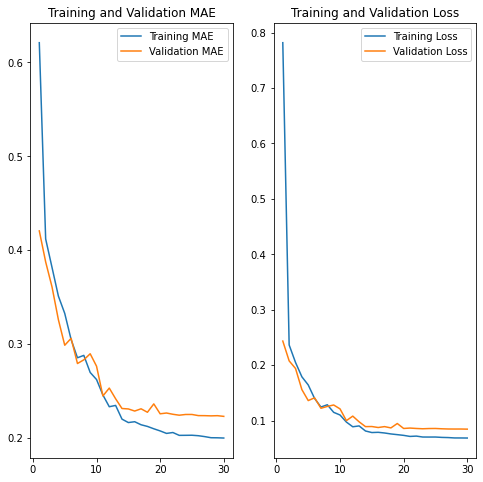

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Osserviamo che, a partire dalla ventesima epoca, le curve di entrambi i campioni non presentano più dei picchi, come accadeva in precedenza, ma tendono a dei valori costanti, come ci aspettiamo che accada usando una CNN funzionante. Tuttavia, le differenze tra i valori asintotici di mae e mse dei campioni di training e di test sono particolarmente elevate, il che può essere riconducibile a problemi di overfitting.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.645789 VS 0.714393 Diff= -0.068604
Predicted vs True T: 4.483494 VS 4.088540 Diff= 0.394954
Predicted vs True T: 2.736301 VS 3.394810 Diff= -0.658509
Predicted vs True T: 2.312876 VS 2.537430 Diff= -0.224554
Predicted vs True T: 2.293510 VS 2.054070 Diff= 0.239440
Predicted vs True T: 4.950479 VS 4.646900 Diff= 0.303579
Predicted vs True T: 4.768429 VS 4.582670 Diff= 0.185759
Predicted vs True T: 3.460725 VS 3.002150 Diff= 0.458575
Predicted vs True T: 1.416200 VS 1.147520 Diff= 0.268680
Predicted vs True T: 0.645789 VS 1.202230 Diff= -0.556441
Sample MAE:  [0.33590946]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.984


L'accuracy sul campione di test rimane quasi invariata rispetto al caso in cui non si utilizzi il learning-rate decay.

#**Utilizzo della data-augmentation**

Proviamo ora a modificare la CNN aggiungendo un layer di data augmentation. Dati i risultati incoraggianti ottenuti in precedenza, manteniamo il learning-rate decay. Grafichiamo nuovamente mse e mae dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0 

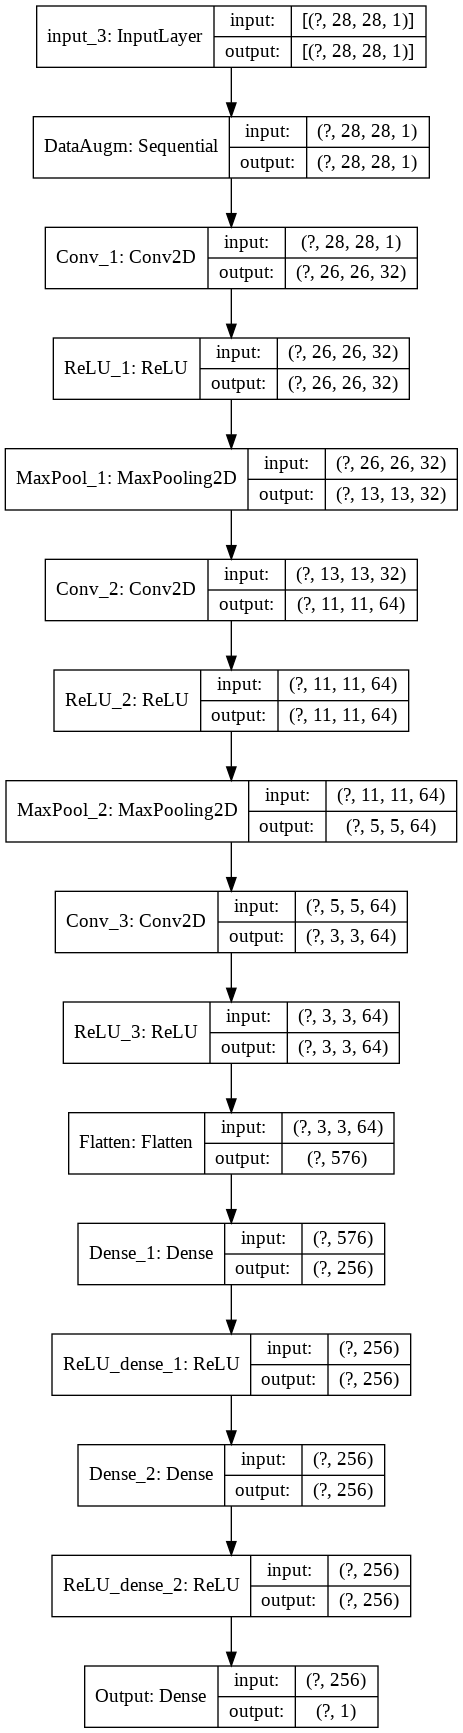

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)


# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [model_checkpoint]
callbacks = [lr_scheduler, model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.8454 - mean_absolute_error: 0.6389 - val_loss: 0.2309 - val_mean_absolute_error: 0.4080 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2244 - mean_absolute_error: 0.4016 - val_loss: 0.1856 - val_mean_absolute_error: 0.3614 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1729 - mean_absolute_error: 0.3423 - val_loss: 0.1598 - val_mean_absolute_error: 0.3236 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1427 - mean_absolute_error: 0.3045 - val_loss: 0.1234 - val_mean_absolute_error: 0.2814 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1246 - mean_absolute_error: 0.2807 - val_loss: 0.1236 - val_mean_absolute_error: 0.2773 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1142 - mean_absolute_error: 0.2655 - val_loss: 0.11

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0855 - mean_absolute_error: 0.2262

Test loss (MSE): 0.08545923978090286

Test MAE: 0.22622954845428467


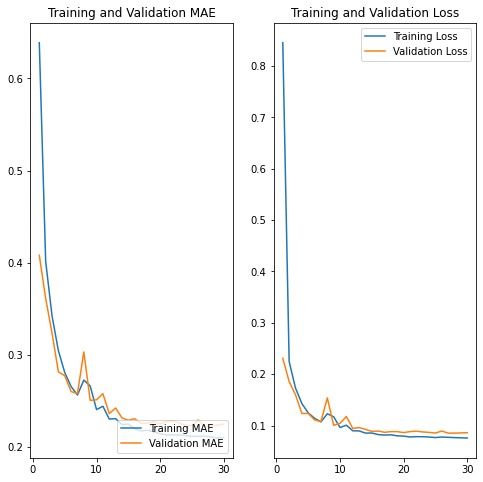

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Notiamo che ora non solo le curve non presentano più dei picchi, una volta raggiunto il valore asintotico, ma che questo coincide, per i campioni di training e di validazione, sia per il *mse* che per il *mae*: abbiamo quindi risolto i problemi di overfitting della rete.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.673291 VS 0.714393 Diff= -0.041102
Predicted vs True T: 4.293847 VS 4.088540 Diff= 0.205307
Predicted vs True T: 2.789022 VS 3.394810 Diff= -0.605788
Predicted vs True T: 2.593903 VS 2.537430 Diff= 0.056473
Predicted vs True T: 2.210026 VS 2.054070 Diff= 0.155956
Predicted vs True T: 4.931717 VS 4.646900 Diff= 0.284817
Predicted vs True T: 4.999861 VS 4.582670 Diff= 0.417191
Predicted vs True T: 3.342495 VS 3.002150 Diff= 0.340345
Predicted vs True T: 1.453146 VS 1.147520 Diff= 0.305626
Predicted vs True T: 0.673291 VS 1.202230 Diff= -0.528939
Sample MAE:  [0.29415432]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.987


L'accuracy è ora diminuita, sebbene di poco, rispetto al valore del 98.4$\%$ ottenuto in precedenza. Questo può essere associato alla risoluzione del problema dell'overfitting, che può aver determinato una accuracy più alta di quella effettivamente ottenibile con una rete di questo tipo.

#**Utilizzo di diverse funzioni di attivazione**

Testiamo ora le performance della rete utilizzando diverse funzioni di attivazione. Ci concentreremo, in particolare, sulla tangente iperbolica, LeakyReLU ed ELU. In tutte le prove che effettueremo manterremo l'utilizzo del layer di data augmentation, nonché del learning-rate decay.

**Tangente iperbolica**

Proviamo per prima la tangente iperbolica.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
tanh_1 (Activation)          (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
tanh_2 (Activation)          (None, 11, 11, 64)        0 

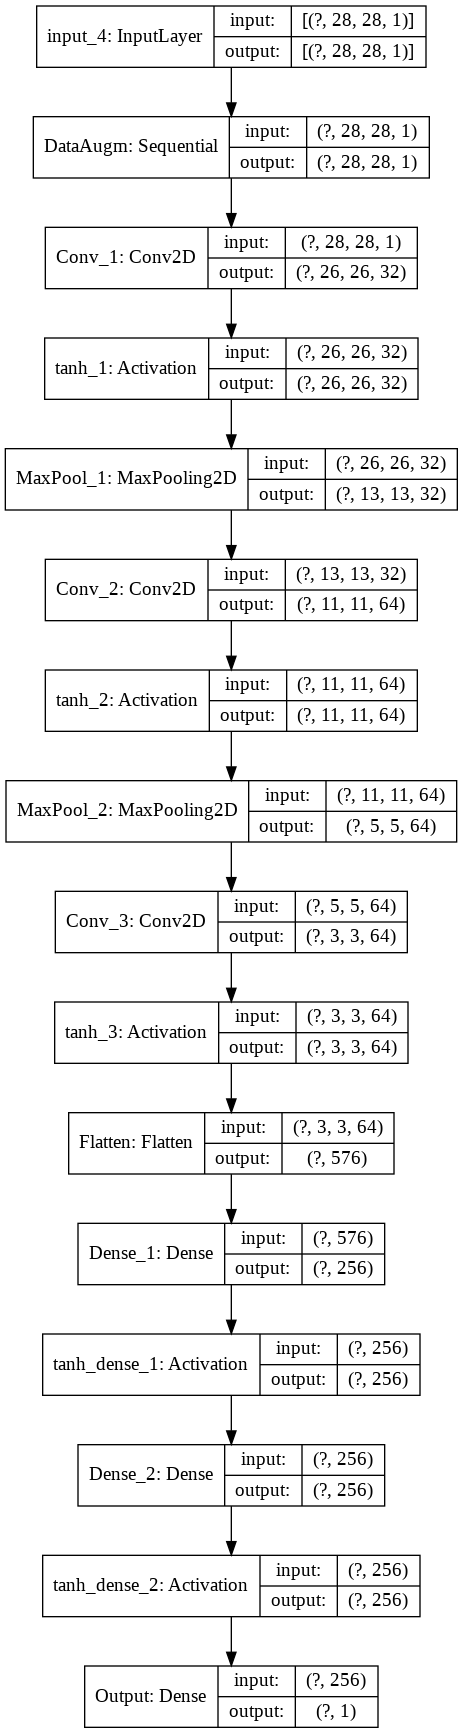

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.Activation('tanh', name='tanh_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.Activation('tanh', name='tanh_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.Activation('tanh', name='tanh_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.Activation('tanh', name='tanh_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.Activation('tanh', name='tanh_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.6900 - mean_absolute_error: 0.6023 - val_loss: 0.2357 - val_mean_absolute_error: 0.4023 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2230 - mean_absolute_error: 0.3934 - val_loss: 0.1951 - val_mean_absolute_error: 0.3645 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1950 - mean_absolute_error: 0.3642 - val_loss: 0.1999 - val_mean_absolute_error: 0.3583 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 9ms/step - loss: 0.1602 - mean_absolute_error: 0.3227 - val_loss: 0.1271 - val_mean_absolute_error: 0.2856 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1415 - mean_absolute_error: 0.2986 - val_loss: 0.1216 - val_mean_absolute_error: 0.2766 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1267 - mean_absolute_error: 0.2817 - val_loss: 0.14

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0944 - mean_absolute_error: 0.2400

Test loss (MSE): 0.09441696852445602

Test MAE: 0.23999078571796417


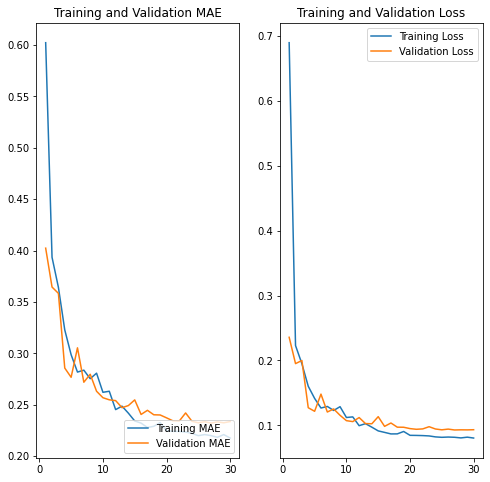

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

L'andamento riscontrato continua ad essere sufficientemente *smooth*. La rete restituisce anche in questo caso delle curve di *mae* e *mse* valide, che non danno segni di evidente overfitting.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.725602 VS 0.714393 Diff= 0.011209
Predicted vs True T: 4.333297 VS 4.088540 Diff= 0.244757
Predicted vs True T: 2.714106 VS 3.394810 Diff= -0.680704
Predicted vs True T: 2.414016 VS 2.537430 Diff= -0.123415
Predicted vs True T: 2.175778 VS 2.054070 Diff= 0.121708
Predicted vs True T: 4.773378 VS 4.646900 Diff= 0.126478
Predicted vs True T: 4.541982 VS 4.582670 Diff= -0.040689
Predicted vs True T: 3.162812 VS 3.002150 Diff= 0.160662
Predicted vs True T: 1.183822 VS 1.147520 Diff= 0.036302
Predicted vs True T: 0.725602 VS 1.202230 Diff= -0.476628
Sample MAE:  [0.20225506]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9835


L'accuracy sul campione di test rimane perlopiù costante.

**LeakyReLU**

Passiamo allo studio di LeakyReLU.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 11, 11, 64)        0 

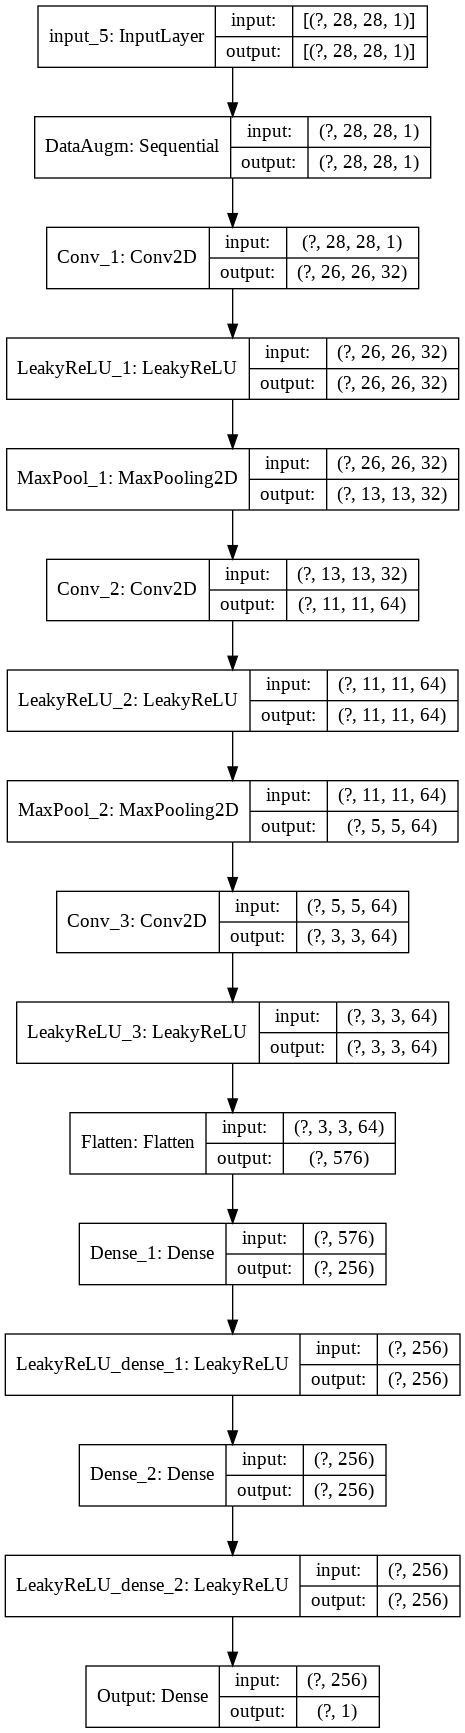

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.7752 - mean_absolute_error: 0.6188 - val_loss: 0.2324 - val_mean_absolute_error: 0.4051 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2098 - mean_absolute_error: 0.3848 - val_loss: 0.1806 - val_mean_absolute_error: 0.3518 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1601 - mean_absolute_error: 0.3282 - val_loss: 0.1493 - val_mean_absolute_error: 0.3111 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1307 - mean_absolute_error: 0.2935 - val_loss: 0.1365 - val_mean_absolute_error: 0.2826 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1376 - mean_absolute_error: 0.2953 - val_loss: 0.1392 - val_mean_absolute_error: 0.2976 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1219 - mean_absolute_error: 0.2750 - val_loss: 0.16

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0863 - mean_absolute_error: 0.2279

Test loss (MSE): 0.08631555736064911

Test MAE: 0.22790968418121338


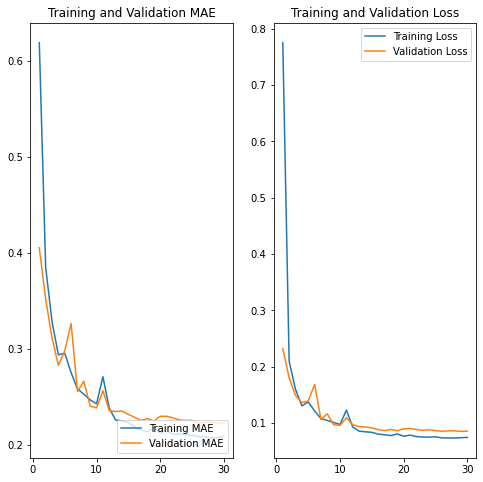

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* del campione di training e di quello di validazione convergono già prima della ventesima epoca, migliorando i risultati ottenuti fino ad ora. Risultando quasi sovrapponibili, possiamo presumere che non sia presente overfitting.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.668922 VS 0.714393 Diff= -0.045471
Predicted vs True T: 4.427722 VS 4.088540 Diff= 0.339182
Predicted vs True T: 2.891435 VS 3.394810 Diff= -0.503375
Predicted vs True T: 2.491108 VS 2.537430 Diff= -0.046322
Predicted vs True T: 2.175746 VS 2.054070 Diff= 0.121676
Predicted vs True T: 4.797945 VS 4.646900 Diff= 0.151045
Predicted vs True T: 4.632249 VS 4.582670 Diff= 0.049579
Predicted vs True T: 3.221345 VS 3.002150 Diff= 0.219195
Predicted vs True T: 1.330543 VS 1.147520 Diff= 0.183023
Predicted vs True T: 0.668922 VS 1.202230 Diff= -0.533308
Sample MAE:  [0.21921754]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.986


L'accuracy sul campione di test migliora, giungendo al 98.6$\%$.

**ELU**

Infine, implementiamo ELU.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ELU_1 (ELU)                  (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ELU_2 (ELU)                  (None, 11, 11, 64)        0 

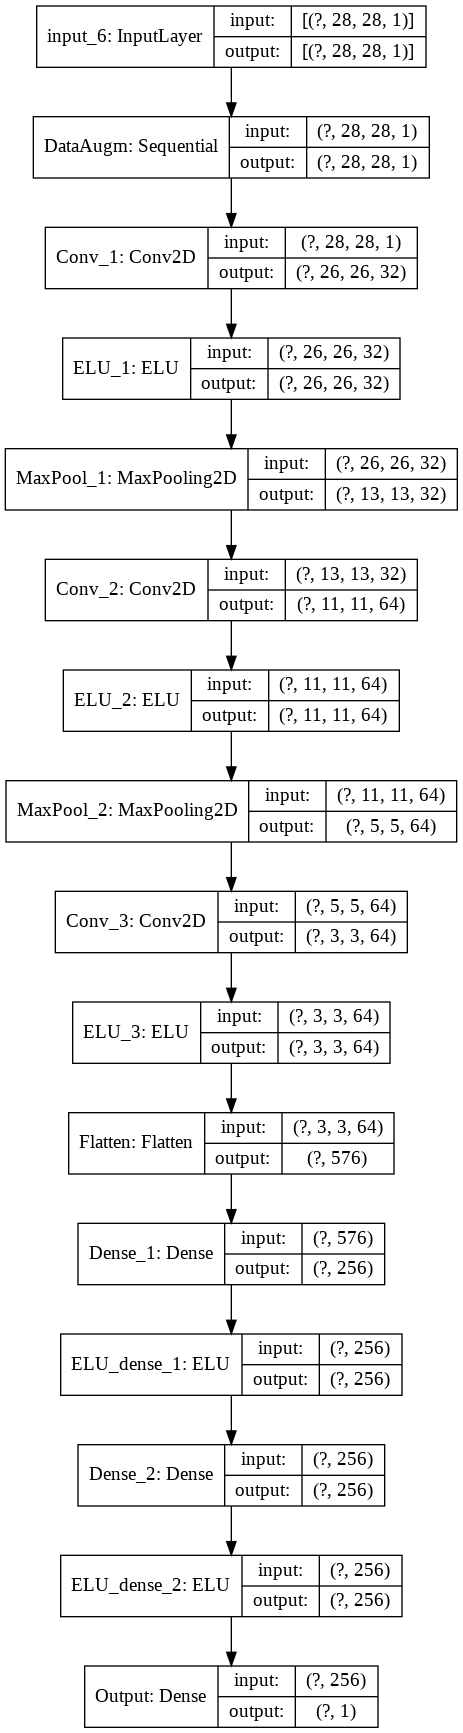

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ELU(name='ELU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ELU(name='ELU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ELU(name='ELU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ELU(name='ELU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ELU(name='ELU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.4455 - mean_absolute_error: 0.4873 - val_loss: 0.1863 - val_mean_absolute_error: 0.3508 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2029 - mean_absolute_error: 0.3639 - val_loss: 0.1544 - val_mean_absolute_error: 0.3248 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1558 - mean_absolute_error: 0.3181 - val_loss: 0.1668 - val_mean_absolute_error: 0.3328 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1357 - mean_absolute_error: 0.2940 - val_loss: 0.1207 - val_mean_absolute_error: 0.2780 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1289 - mean_absolute_error: 0.2855 - val_loss: 0.1667 - val_mean_absolute_error: 0.3261 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1187 - mean_absolute_error: 0.2726 - val_loss: 0.11

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0884 - mean_absolute_error: 0.2322

Test loss (MSE): 0.08835731446743011

Test MAE: 0.23222015798091888


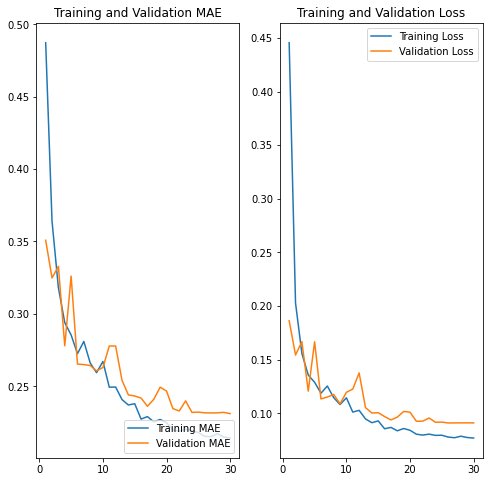

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* convergono anche utilizzando ELU come funzione di attivazione, sebbene tale convergenza sia ora più tardiva e gli andamenti non siano perfettamente sovrapponibili (come abbiamo osservato, invece, con LeakyReLU).

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.665556 VS 0.714393 Diff= -0.048837
Predicted vs True T: 4.441241 VS 4.088540 Diff= 0.352701
Predicted vs True T: 2.880608 VS 3.394810 Diff= -0.514202
Predicted vs True T: 2.361047 VS 2.537430 Diff= -0.176383
Predicted vs True T: 2.181353 VS 2.054070 Diff= 0.127283
Predicted vs True T: 4.869780 VS 4.646900 Diff= 0.222879
Predicted vs True T: 4.715792 VS 4.582670 Diff= 0.133122
Predicted vs True T: 3.181817 VS 3.002150 Diff= 0.179667
Predicted vs True T: 1.291574 VS 1.147520 Diff= 0.144054
Predicted vs True T: 0.665556 VS 1.202230 Diff= -0.536674
Sample MAE:  [0.2435801]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9845


L'accuracy sul campione di test peggiora leggermente, risultando ora 97.9$\%$.

#**Utilizzo di Keras Tuner**

Per ottimizzare la rete creata, utilizziamo la tecnica del tuning degli iperparametri, mediante *keras tuner*. Modifichiamo la rete in modo che accetti un parametro (ovvero un iperparametro) che possa essere ottimizzato dal *tuner*. Si fa dunque iterare l'algoritmo più volte, in modo da ottenere la migliore stima del parametro da utilizzare. <br />
Anche in questo caso manteniamo il layer di data augmentation ed il learning-rate decay. Sostituiamo però la funzione di attivazione ReLU con LeakyReLU, in quanto abbiamo ottenuto risultati migliori con essa.

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))

  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')

  x = data_augmentation(inputs)

  #first convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=16, max_value=128, step=16),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  #second convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  #third convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  x = keras.layers.Flatten()(x)
  
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)
  
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)
  
  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  return model

In [0]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 4.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=8771bf33e5fdba08d4d25bf4f38c412940c4197a45af19d11c0d1cee229d318d
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=c93a113a8a7a19b2adda9d11b20643121c599e07d862f2bb0037ab589eb93b4d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='dir')

In [0]:
# start optimisation search
X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

Epoch 1/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4838 - mae: 0.5125 - val_loss: 0.2080 - val_mae: 0.3855
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1932 - mae: 0.3665 - val_loss: 0.1800 - val_mae: 0.3502
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1588 - mae: 0.3307 - val_loss: 0.1608 - val_mae: 0.3285
Epoch 4/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1339 - mae: 0.2998 - val_loss: 0.1595 - val_mae: 0.3271
Epoch 5/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1211 - mae: 0.2832 - val_loss: 0.1386 - val_mae: 0.3054
Epoch 6/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1071 - mae: 0.2655 - val_loss: 0.1574 - val_mae: 0.3211
Epoch 7/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0999 - mae: 0.2561 - val_loss: 0.1233 - val_mae: 0.2793
Epoch 8/10
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 9ms/step - loss: 1.9740 - mae: 0.6936 - val_loss: 0.1737 - val_mae: 0.3476
Epoch 2/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1807 - mae: 0.3431 - val_loss: 0.1461 - val_mae: 0.3152
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1401 - mae: 0.2996 - val_loss: 0.2684 - val_mae: 0.4121
Epoch 4/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1275 - mae: 0.2833 - val_loss: 0.1317 - val_mae: 0.2806
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1208 - mae: 0.2746 - val_loss: 0.1329 - val_mae: 0.2895
Epoch 6/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1160 - mae: 0.2695 - val_loss: 0.1123 - val_mae: 0.2734
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0909 - mae: 0.2390 - val_loss: 0.1219 - val_mae: 0.2806
Epoch 8/10
125/125 [==============================] - 2s 12ms/step - loss: 0

Epoch 1/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4327 - mae: 0.4847 - val_loss: 0.2004 - val_mae: 0.3824
Epoch 2/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1904 - mae: 0.3696 - val_loss: 0.1832 - val_mae: 0.3638
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1697 - mae: 0.3458 - val_loss: 0.1659 - val_mae: 0.3369
Epoch 4/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1427 - mae: 0.3133 - val_loss: 0.1586 - val_mae: 0.3320
Epoch 5/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1287 - mae: 0.2940 - val_loss: 0.1398 - val_mae: 0.3093
Epoch 6/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1116 - mae: 0.2722 - val_loss: 0.1259 - val_mae: 0.2840
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1025 - mae: 0.2587 - val_loss: 0.1221 - val_mae: 0.2795
Epoch 8/10
125/125 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 8ms/step - loss: 2.6812 - mae: 0.8030 - val_loss: 0.3055 - val_mae: 0.4420
Epoch 2/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1902 - mae: 0.3604 - val_loss: 0.2404 - val_mae: 0.3797
Epoch 3/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1612 - mae: 0.3217 - val_loss: 0.1351 - val_mae: 0.3017
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1616 - mae: 0.3208 - val_loss: 0.1609 - val_mae: 0.3172
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1177 - mae: 0.2773 - val_loss: 0.1493 - val_mae: 0.3110
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0995 - mae: 0.2523 - val_loss: 0.1281 - val_mae: 0.2743
Epoch 7/10
125/125 [==============================] - 2s 19ms/step - loss: 0.0945 - mae: 0.2449 - val_loss: 0.1237 - val_mae: 0.2678
Epoch 8/10
125/125 [==============================] - 1s 8ms/step - loss: 0

Epoch 1/10
125/125 [==============================] - 1s 5ms/step - loss: 0.6632 - mae: 0.5282 - val_loss: 0.1605 - val_mae: 0.3318
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1714 - mae: 0.3347 - val_loss: 0.1710 - val_mae: 0.3383
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1288 - mae: 0.2890 - val_loss: 0.1196 - val_mae: 0.2695
Epoch 4/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1167 - mae: 0.2716 - val_loss: 0.1252 - val_mae: 0.2868
Epoch 5/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1075 - mae: 0.2586 - val_loss: 0.1069 - val_mae: 0.2645
Epoch 6/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0987 - mae: 0.2477 - val_loss: 0.1085 - val_mae: 0.2584
Epoch 7/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0862 - mae: 0.2306 - val_loss: 0.1126 - val_mae: 0.2609
Epoch 8/10
125/125 [==============================] - 1s 4ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 9ms/step - loss: 0.3725 - mae: 0.4620 - val_loss: 0.1757 - val_mae: 0.3526
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1647 - mae: 0.3366 - val_loss: 0.2104 - val_mae: 0.3749
Epoch 3/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1256 - mae: 0.2871 - val_loss: 0.1251 - val_mae: 0.2871
Epoch 4/10
125/125 [==============================] - 1s 8ms/step - loss: 0.1029 - mae: 0.2564 - val_loss: 0.1126 - val_mae: 0.2677
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0914 - mae: 0.2411 - val_loss: 0.1504 - val_mae: 0.3078
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0775 - mae: 0.2206 - val_loss: 0.1417 - val_mae: 0.3012
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0790 - mae: 0.2216 - val_loss: 0.1235 - val_mae: 0.2748
Epoch 8/10
125/125 [==============================] - 1s 9ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 0.3514 - mae: 0.4552 - val_loss: 0.1828 - val_mae: 0.3607
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1809 - mae: 0.3490 - val_loss: 0.1604 - val_mae: 0.3360
Epoch 3/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1300 - mae: 0.2937 - val_loss: 0.1435 - val_mae: 0.3067
Epoch 4/10
125/125 [==============================] - 2s 13ms/step - loss: 0.1096 - mae: 0.2651 - val_loss: 0.1186 - val_mae: 0.2739
Epoch 5/10
125/125 [==============================] - 2s 14ms/step - loss: 0.1014 - mae: 0.2534 - val_loss: 0.1162 - val_mae: 0.2736
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0865 - mae: 0.2329 - val_loss: 0.1101 - val_mae: 0.2629
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0797 - mae: 0.2236 - val_loss: 0.1113 - val_mae: 0.2662
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss: 

Epoch 1/10
125/125 [==============================] - 1s 9ms/step - loss: 4327.9707 - mae: 13.1184 - val_loss: 0.3185 - val_mae: 0.4792
Epoch 2/10
125/125 [==============================] - 1s 9ms/step - loss: 0.2991 - mae: 0.4558 - val_loss: 0.2408 - val_mae: 0.4101
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2819 - mae: 0.4412 - val_loss: 0.2490 - val_mae: 0.4083
Epoch 4/10
125/125 [==============================] - 1s 9ms/step - loss: 0.3324 - mae: 0.4650 - val_loss: 0.1882 - val_mae: 0.3681
Epoch 5/10
125/125 [==============================] - 1s 8ms/step - loss: 0.2269 - mae: 0.3900 - val_loss: 0.1641 - val_mae: 0.3363
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2202 - mae: 0.3772 - val_loss: 0.3963 - val_mae: 0.5091
Epoch 7/10
125/125 [==============================] - 1s 8ms/step - loss: 0.2206 - mae: 0.3733 - val_loss: 0.1423 - val_mae: 0.3075
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss

Epoch 1/10
125/125 [==============================] - 1s 6ms/step - loss: 0.3972 - mae: 0.4730 - val_loss: 0.1908 - val_mae: 0.3701
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1766 - mae: 0.3503 - val_loss: 0.1678 - val_mae: 0.3378
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1356 - mae: 0.3003 - val_loss: 0.1717 - val_mae: 0.3189
Epoch 4/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1186 - mae: 0.2771 - val_loss: 0.1369 - val_mae: 0.2867
Epoch 5/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1123 - mae: 0.2669 - val_loss: 0.1431 - val_mae: 0.2995
Epoch 6/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0880 - mae: 0.2343 - val_loss: 0.1469 - val_mae: 0.2990
Epoch 7/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0777 - mae: 0.2195 - val_loss: 0.1150 - val_mae: 0.2733
Epoch 8/10
125/125 [==============================] - 1s 9ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 5ms/step - loss: 0.3076 - mae: 0.4136 - val_loss: 0.1472 - val_mae: 0.3203
Epoch 2/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1311 - mae: 0.2932 - val_loss: 0.1285 - val_mae: 0.2900
Epoch 3/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1106 - mae: 0.2673 - val_loss: 0.1135 - val_mae: 0.2695
Epoch 4/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0907 - mae: 0.2389 - val_loss: 0.1056 - val_mae: 0.2597
Epoch 5/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0877 - mae: 0.2340 - val_loss: 0.1513 - val_mae: 0.3178
Epoch 6/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0850 - mae: 0.2295 - val_loss: 0.1004 - val_mae: 0.2487
Epoch 7/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0737 - mae: 0.2115 - val_loss: 0.1321 - val_mae: 0.2857
Epoch 8/10
125/125 [==============================] - 1s 5ms/step - loss: 0.

INFO:tensorflow:Oracle triggered exit


In [0]:
# Results
tuner.results_summary()

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=2)

In [0]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = models[0].fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0681 - mae: 0.1977 - val_loss: 0.0683 - val_mae: 0.1968 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0618 - mae: 0.1885 - val_loss: 0.0716 - val_mae: 0.2053 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0595 - mae: 0.1850 - val_loss: 0.0840 - val_mae: 0.2227 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0589 - mae: 0.1838 - val_loss: 0.0691 - val_mae: 0.1980 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0532 - mae: 0.1765 - val_loss: 0.0687 - val_mae: 0.2007 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0498 - mae: 0.1690 - val_loss: 0.0712 - val_mae: 0.2043 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0527 - mae: 0.1745 - val_loss: 0.0707 - val_mae: 0.2040 - lr: 0.0010

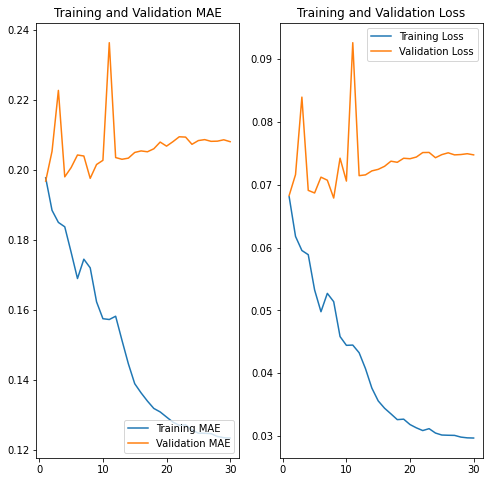

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mae']
val_mae = history.history['val_mae']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* non convergono, né risultano sovrapponibili. Osserviamo un miglioramento rispetto alla prima rete utilizzata, poiché i valori di *mae* e *mse* del campione di validazione sono ora minori e più vicini a quelli del campione di training, ma questo potrebbe essere dovuto alla sostituzione di ReLU con LeakyReLU.

In [0]:
test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0911 - mae: 0.2302

Test loss (MSE): 0.09110094606876373

Test MAE: 0.23023290932178497


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = models[0].predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)

Accuracy is:  0.9745


L'accuracy sul campione di test scende, arrivando al 97.5$\%$.

#**Batch-Normalization layer**

Testiamo ora la stessa rete di partenza, ma con l'aggiunta di due *batch-normalization layers* nei primi due blocchi convoluzionali. Grafichiamo il *mse* e il *mae* dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
ReLu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        25

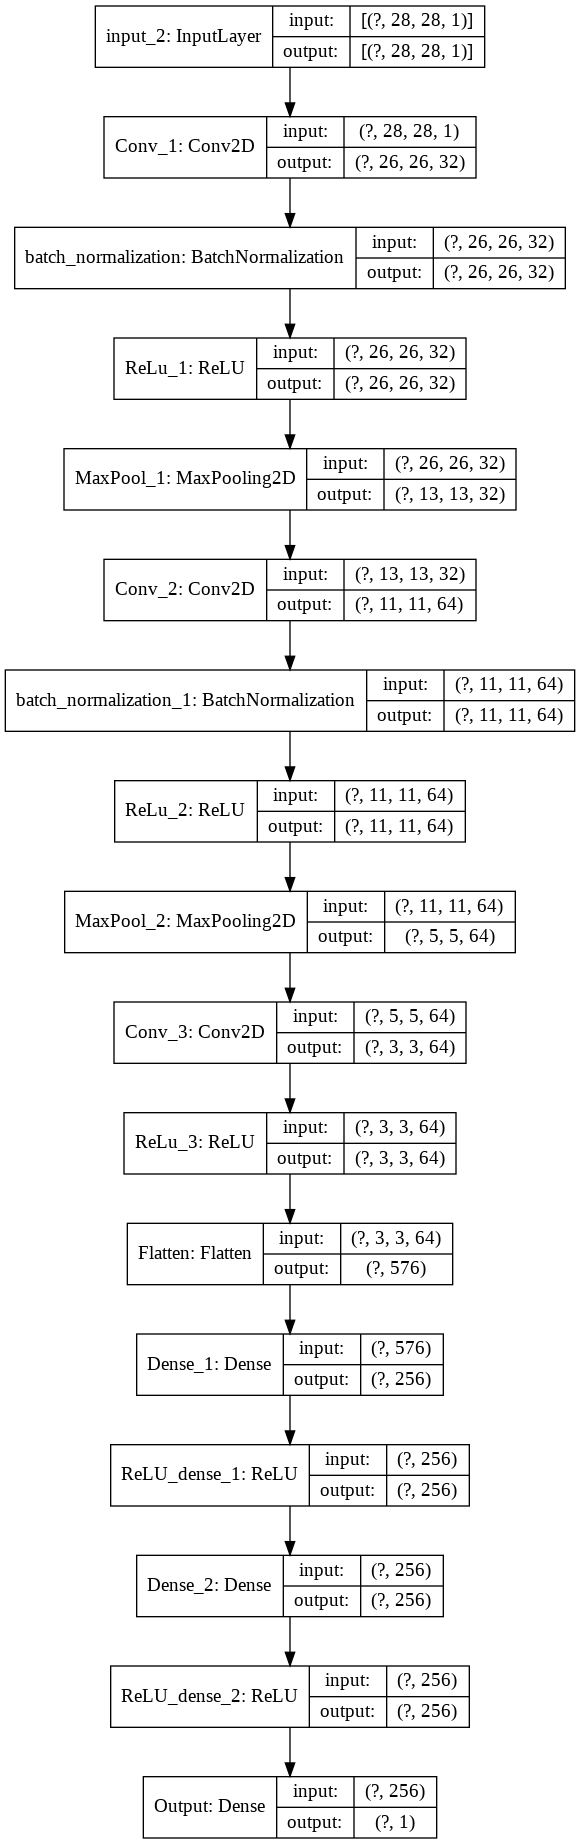

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

x = inputs


# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLu_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLu_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLu_3')(x)


# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [model_checkpoint]
callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 10ms/step - loss: 0.5792 - mean_absolute_error: 0.5119 - val_loss: 5.2085 - val_mean_absolute_error: 1.9580
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1830 - mean_absolute_error: 0.3372 - val_loss: 5.9768 - val_mean_absolute_error: 2.0926
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2262 - mean_absolute_error: 0.3704 - val_loss: 5.4467 - val_mean_absolute_error: 1.9770
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1967 - mean_absolute_error: 0.3483 - val_loss: 4.5064 - val_mean_absolute_error: 1.7917
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1455 - mean_absolute_error: 0.2986 - val_loss: 3.7616 - val_mean_absolute_error: 1.6475
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1351 - mean_absolute_error: 0.2857 - val_loss: 2.4944 - val_mean_absolute_error: 1.3373
Epoch 7/30
50/50 [=========

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.1296 - mean_absolute_error: 0.2801

Test loss (MSE): 0.12962529063224792

Test MAE: 0.2800642251968384


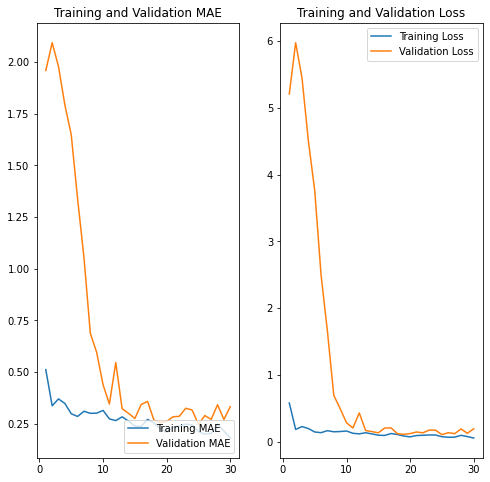

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

La convergneza delle curve è più rapida di quanto osservato in precedenza. Anche in questo caso non si riscontrano problemi di overfitting, ma i valori assunti dalle curve nella regione di convergenza sembrano variare di più rispetto al caso in cui si è implementata la *data augmentation*.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.552754 VS 0.714393 Diff= -0.161639
Predicted vs True T: 4.715795 VS 4.088540 Diff= 0.627255
Predicted vs True T: 3.345762 VS 3.394810 Diff= -0.049048
Predicted vs True T: 2.717347 VS 2.537430 Diff= 0.179917
Predicted vs True T: 1.978964 VS 2.054070 Diff= -0.075106
Predicted vs True T: 5.370097 VS 4.646900 Diff= 0.723197
Predicted vs True T: 4.760834 VS 4.582670 Diff= 0.178164
Predicted vs True T: 3.476865 VS 3.002150 Diff= 0.474715
Predicted vs True T: 1.431335 VS 1.147520 Diff= 0.283815
Predicted vs True T: 0.552754 VS 1.202230 Diff= -0.649476
Sample MAE:  [0.34023318]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9825


Anche in questo caso l'accuracy è calata rispetto al valore di riferimento del caso senza *data augmentation* e *batch-normalization layer*. La non perfetta convergenza delle curve di *mse* e *mae* può essere annoverata tra le possibili cause di questo calo.